Importing the libraries

In [22]:
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_absolute_error, mean_squared_error  
import matplotlib.pyplot as plt  
import seaborn as sns

Exploring and Preprocessing the dataset

In [5]:
df = pd.read_csv('superstore_sales.csv')  
print(df.head())  # To View first 5rows

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

In [ ]:
print(df.info()) #To check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
print(df.describe())  # Summary stats

            Row ID   Postal Code         Sales
count  9800.000000   9789.000000   9800.000000
mean   4900.500000  55273.322403    230.769059
std    2829.160653  32041.223413    626.651875
min       1.000000   1040.000000      0.444000
25%    2450.750000  23223.000000     17.248000
50%    4900.500000  58103.000000     54.490000
75%    7350.250000  90008.000000    210.605000
max    9800.000000  99301.000000  22638.480000


In [7]:
# Handle missing values 
df = df.dropna()

In [9]:
# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

In [ ]:
# Handle outliers: Remove sales values beyond 3 standard deviations from the mean 
sales_mean = df['Sales'].mean()  # Calculate mean of 'Sales'.
sales_std = df['Sales'].std()  # Calculate standard deviation of 'Sales'.
df = df[(df['Sales'] > sales_mean - 3 * sales_std) & (df['Sales'] < sales_mean + 3 * sales_std)]  # Filters outliers.

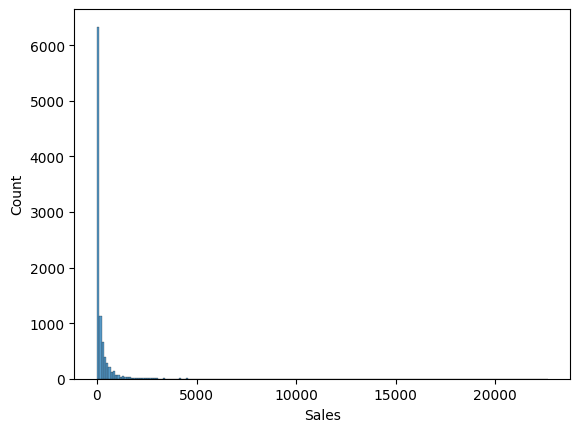

In [ ]:
# Visualize sales distribution with a histogram.
sns.histplot(df['Sales'])
plt.show()  

In [11]:
# Aggregate daily data to monthly sales for forecasting (sum sales per month).
df['Month'] = df['Order Date'].dt.to_period('M')  # Extract month-year period from date.
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()  # Group by month and sum sales, reset index for clean DataFrame.
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()  # Convert period back to timestamp for easier handling.

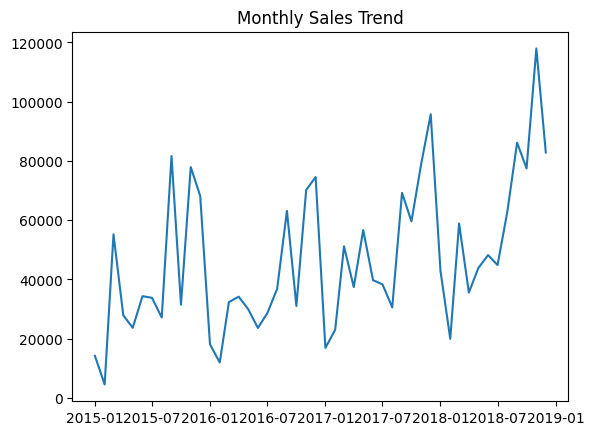

In [ ]:
# Plotting the monthly sales trend to visualize patterns.
plt.plot(monthly_sales['Month'], monthly_sales['Sales'])
plt.title('Monthly Sales Trend')  # Add title to plot.
plt.show()  # Display the plot.

Feature Engineering

In [ ]:
# Creating new features for modeling: Year and Month number for seasonality.
monthly_sales['Year'] = monthly_sales['Month'].dt.year  # Extract year from 'Month'.
monthly_sales['Month_Num'] = monthly_sales['Month'].dt.month  # Extract month number (1-12).

In [ ]:
# Creating a lag feature: Previous month's sales (shift by 1).
monthly_sales['Lag_1'] = monthly_sales['Sales'].shift(1)

In [ ]:
# Creating a rolling mean: Average of last 3 months' sales for trend smoothing.
monthly_sales['Rolling_Mean_3'] = monthly_sales['Sales'].rolling(window=3).mean()

In [ ]:
# Dropping rows with NaNs created by shifting/rolling (first few rows lack prior data).
monthly_sales = monthly_sales.dropna()

In [18]:
# Selecting features for modeling.
features = ['Year', 'Month_Num', 'Lag_1', 'Rolling_Mean_3']  # List of feature columns.
X = monthly_sales[features]  # Feature matrix.
y = monthly_sales['Sales']  # Target vector (sales to predict).

Splitting the data

In [19]:
# Split into train/test sets: 80% train, 20% test, no shuffle to preserve time order.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Training and Evaluating Models

In [20]:
# Model 1: Linear Regression
lr_model = LinearRegression()  # Initialize the model.
lr_model.fit(X_train, y_train)  # Train on training data.
lr_y_pred = lr_model.predict(X_test)  # Predict on test data.

In [23]:
# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Initialize with 100 trees, fixed seed for reproducibility.
rf_model.fit(X_train, y_train)  # Train on training data.
rf_y_pred = rf_model.predict(X_test)  # Predict on test data.

Evaluating the models

In [24]:
# Calculate metrics for Linear Regression.
lr_mae = mean_absolute_error(y_test, lr_y_pred)  # Mean Absolute Error: Average absolute difference between actual and predicted.
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_y_pred))  # Root Mean Squared Error: Square root of average squared differences (penalizes large errors).
print(f'Linear Regression - MAE: {lr_mae}, RMSE: {lr_rmse}')

Linear Regression - MAE: 9562.501992415026, RMSE: 12152.582491097151


In [ ]:
# Calculate metrics for Random Forest.
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print(f'Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}')

Random Forest - MAE: 13117.434674800013, RMSE: 16764.085636949625


In [26]:
# Compare and conclude which is better (lower errors = better).
if rf_rmse < lr_rmse:
    print("Random Forest is better based on lower RMSE.")
else:
    print("Linear Regression is better based on lower RMSE.")

Linear Regression is better based on lower RMSE.


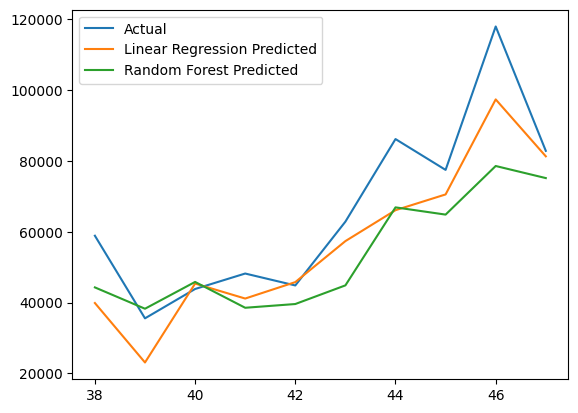

In [ ]:
# Plot predictions vs actual for both models (visual comparison).
plt.plot(y_test.index, y_test, label='Actual')  
plt.plot(y_test.index, lr_y_pred, label='Linear Regression Predicted')  
plt.plot(y_test.index, rf_y_pred, label='Random Forest Predicted')
plt.legend()  
plt.show()  


In [29]:
# Simple Prediction for next month 
# Get last row's data to base next prediction on.
last_data = monthly_sales.iloc[-1]
# Create input for next month: Increment month/year, use last sales as lag, recalculate rolling mean.
next_month = pd.DataFrame({
    'Year': [last_data['Year'] if last_data['Month_Num'] < 12 else last_data['Year'] + 1],
    'Month_Num': [last_data['Month_Num'] + 1 if last_data['Month_Num'] < 12 else 1],
    'Lag_1': [last_data['Sales']],
    'Rolling_Mean_3': [monthly_sales['Sales'].tail(3).mean()]
})
# Predict with Linear Regression.
next_pred = lr_model.predict(next_month)
print(f'Predicted next month sales (using Linear Regression): {next_pred[0]}')

Predicted next month sales (using Linear Regression): 60804.77131362978
